# Paavo Reinikka, 589479

In [1]:
%config Completer.use_jedi = False

# Lab exercise #2: Gaussian process basics 

### Learning objectives


- Implement the squared exponential kernel and explain the interpretation of each parameter


- Generate samples from a Gaussian process prior


- Compute the posterior & predictive distributions for a Gaussian process model with Gaussian likelihood


- Compute the marginal likelihood and use it for model selection



In [1]:
%matplotlib inline
import numpy as np
import pylab as plt
import seaborn as snb
snb.set(font_scale=1.5)

### Task 1: The squared exponential kernel

The squared exponential covariance function is given by

\begin{align}
    k(\mathbf{x}_n, \mathbf{x}_m) = \alpha \exp\left(-\frac{\|\mathbf{x}_n - \mathbf{x}_m\|^2_ 2}{2\ell^2}\right),
\end{align}

where $\alpha > 0$ and $\ell > 0$ are hyperparameters of the kernel. This specific covariance function is perhaps the most common covariance function used in statistics and machine learning. It is also known as the radial basis function kernel, the gaussian kernel, or the exponeniated quadratic kernel. 

Below you are given a vector $\mathbf{X}^p \in \mathbb{R}^{N \times 1}$ of $N = 50$ points on the real line. The points are sorted and equidistantly distributed in the interval $\left[-3, 9\right]$. 

- **Task 1a**: Complete the implementation of the squared exponential kernel function below. (Hint: the code only needs to work with $D=1$).

- **Task 1b**: Use the kernel function to compute the $N\times N$ kernel matrix for the points $\mathbf{X}^p$ with $\alpha=1$ and $\ell=1$. These points will be used for predictions later and hence, the superscript 'p'. Visualize the kernel function as an image and give an interpretation of the structure of the kernel. ('imshow' function)

- **Task 1c**: Try few other parameter values $\alpha, \ell$ and explain how they affect the structure of the kernel.

### 1a (Kernel implementation)

**Note: I am using numpy broadcasting rules to calculate the kernel - this way seemed the fastest.**

In [ ]:
# create an Nx1 vector of equidistant points in [-3, 3]
N = 50
Xp = np.linspace(-3, 9, N)[:, None]

def create_se_kernel(X1, X2, alpha=1, scale=1):
    """ returns the NxM kernel matrix between the two sets of input X1 and X2 
    
    arguments:
    X1    -- NxD matrix
    X2    -- MxD matrix
    alpha -- scalar 
    scale -- scalar
    
    returns NxM matrix    
    """
    
    a = -1./(2*scale**2)
    #These are broadcasting (N,M) + (N,1) + (1,M) -> (N,M)
    return alpha * np.exp(a * ( -2*X1@X2.T \
                        + np.sum(X1**2,axis=1, keepdims=True)\
                        + np.sum(X2**2,1)))

### 1b-c (Visualizing and explaining the kernel)
**Note: I am doing both 1b and 1c with these visualizations. The first 3 images are scaled to interval
[0,5], to show the effect of alpha parameter. The second row has default [0,1] output scale.**

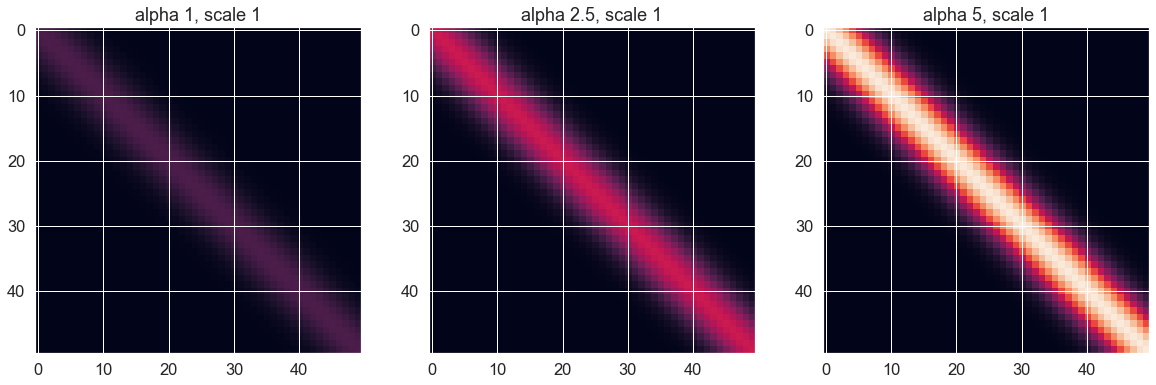

In [3]:
#THESE ARE SCALED TO [0,5], TO DEMONSTRATE THE ALPHA PARAM BETTER
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.imshow(create_se_kernel(Xp,Xp), vmin=0,vmax=5)
plt.title("alpha 1, scale 1")
plt.subplot(1, 3, 2)
plt.imshow(create_se_kernel(Xp,Xp,alpha=2.5), vmin=0,vmax=5)
plt.title("alpha 2.5, scale 1")
plt.subplot(1, 3, 3)
plt.imshow(create_se_kernel(Xp,Xp,alpha=5), vmin=0,vmax=5)
plt.title("alpha 5, scale 1")
plt.show()

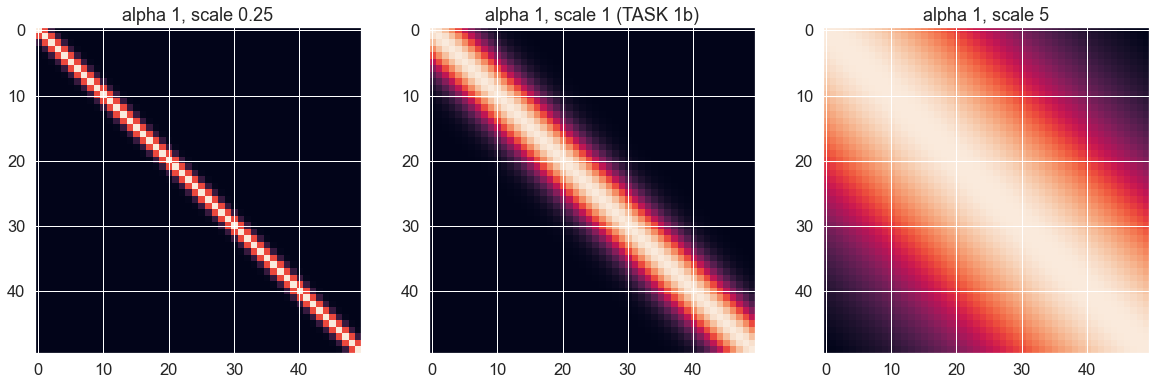

In [4]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.imshow(create_se_kernel(Xp,Xp,scale=0.25))
plt.title("alpha 1, scale 0.25")
plt.subplot(1, 3, 2)
plt.imshow(create_se_kernel(Xp,Xp,scale=1))
plt.title("alpha 1, scale 1 (TASK 1b)")
plt.subplot(1, 3, 3)
plt.imshow(create_se_kernel(Xp,Xp,scale=5))
plt.title("alpha 1, scale 5")
plt.show()

**Explanation:**
The kernel(image) diagonal (core) shows the variance (default scaling obscures this somewhat), and the thickness of
it reflects how far the training points can effect each others. With large scale param, even far-apart points are correlated.
With small lengthscale, only close-by points are correlated (GPs are wiggly/non-smooth).

The lengthscale defines how far apart different points are correlated, and the parameter alpha defines
 the variance (amplitude of the Gaussian process). One way to view the scale parameter, is as the unit of length after which the the
correlation decreases by an order of magnitude (i.e., it is the normalizing factor $\mathcal{l}$
in $\dfrac{x_i-x_j}{\mathcal{l}}$). In practice, the larger the $\mathcal{l}$ is, more data points contribute to the
value at a given query point (and the smoother the function is).

If one concentrates on a single observation point (after drawing a sample of functions from GP prior),
the variance parameter defines how large the variance is on that single observation point. On the other hand,
the lengthscale defines the size of an interval within which the function values stay close to each others
(such interval would be proportional to $\mathcal{l}$, and the notion of "closeness" would depend on $\alpha$).

### Task 2: Sampling from a Gaussian process

We will consider a zero-mean Gaussian process prior for functions of the form $f: \mathbb{R} \rightarrow \mathbb{R}$ using the squared exponential kernel from task 1). That is,

\begin{align}
f(x) \sim \mathcal{GP}\left(0 \, , \, k\left(x, x'\right)\right).
\end{align}

Let $f_n = f(x_n) \in \mathbb{R}$ be the value of the function $f$ evaluated at a point $x_n \in \mathbb{R}$. Furthermore, let $\mathbf{f} = \left[f_1, f_2, \dots, f_N\right] \in \mathbb{R}^{N \times 1}$ be the vector of function values for each of the points of $\mathbf{X}^p$ from task 1. 

The Gaussian process prior for $\mathbf{f}$ becomes

\begin{align}
\mathbf{f} \sim \mathcal{N}\left(\mathbf{0}, \mathbf{K}\right),
\end{align}

where $\mathbf{K}$ is the kernel matrix you generated previously.

- **Task 2a**: Complete the implementation of the sampling function given below. Hint: You can re-use the code from first exercise.


- **Task 2b**: Generate $M = 10$ samples using the new function and plot them


- **Task 2c**: Change the parameters $\alpha, \ell$ and explain how they affect the generated samples.

### 2a (sampling function)

In [ ]:
def generate_samples(mean, K, M):
    """ returns M samples from a zero-mean Gaussian process with kernel matrix K
    
    arguments:
    K   -- NxN kernel matrix
    M   -- number of samples (scalar)
    
    returns NxM matrix
    """
    
    jitter = 1e-8
    D = K.shape[0]
    L = np.linalg.cholesky(K + jitter*np.identity(D))
    zs = np.random.normal(0, 1, size=(D, M)) # samples standard Gaussian, and...
    fs = mean + np.dot(L, zs) # mean shifts by mu and scales/rotates with Chol
    return fs


### 2b (10 samples with default params)

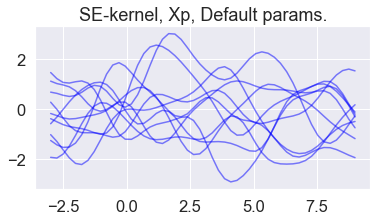

In [6]:
res = generate_samples(0, create_se_kernel(Xp,Xp,1,1),10)
plt.figure(figsize=(6, 3))
plt.plot(Xp,res,color="blue",alpha=.5)
plt.title("SE-kernel, Xp, Default params.")
plt.show()

### 2c (samples from prior with different param values)

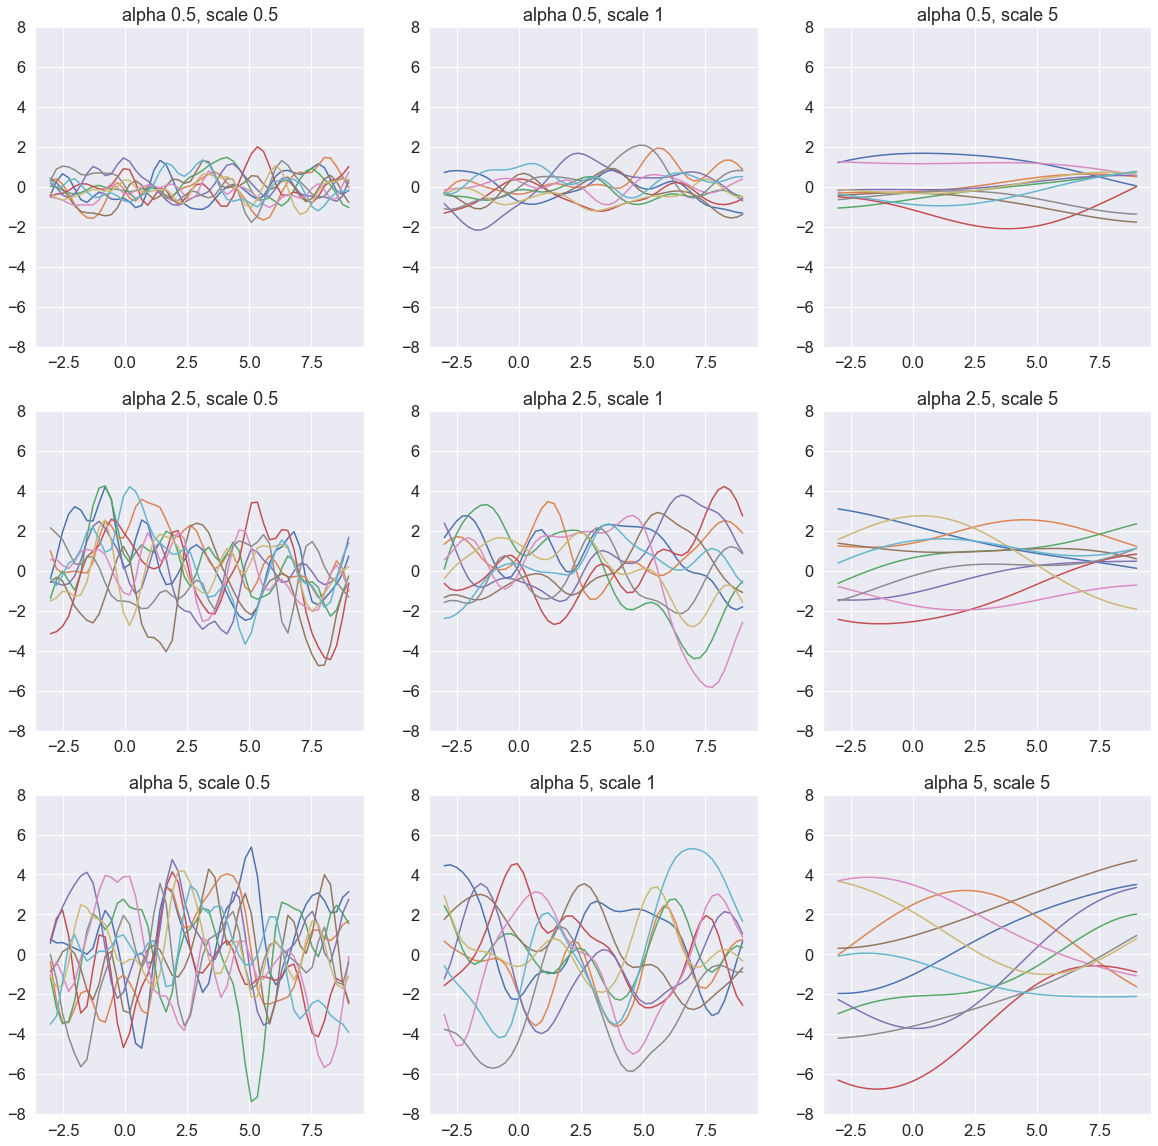

In [7]:
alp = [0.5,2.5,5]
sc = [0.5,1,5]
k=0
plt.figure(figsize=(20, 20))
for i in range(3):
    for j in range(3):
        k+=1
        plt.subplot(3,3,k)
        plt.plot(Xp,generate_samples(0,create_se_kernel(Xp,Xp,alp[i],sc[j]),10))
        plt.ylim([-8,8])
        plt.title("alpha {}, scale {}".format(np.round(alp[i],2),np.round(sc[j],2)))

**Explanation:**
Some of the explanation is already given in the previous task in context of the kernel. Small scale produces
very non-smooth/wiggly GPs/functions, since only close points are correlated (the window over which any smoothing
could happen is very small). Growing the lengthscale makes the functions more stiff/smooth (averaging effect).

The alpha/variance parameter modulates how large variance/magnitude the functions can have. This can be roughly
viewed as "amplitude" of the process - however, it is noteworthy, that when the process has a large lengthscale,
the stiffness/smoothness of it also limits how much the function values can vary (this can be seen in the plots
of the right-most column).

### Task 3: The analytical posterior distribution

The goal of this task is complete the implementation of the function below for computing the analytical posterior distribution for a Gaussian process model with Gaussian likelihood, respectively, using the squared exponential kernel.

The joint model for the training data is as follows:
\begin{align}
p(\mathbf{y}, \mathbf{f}) = \mathcal{N}\left(\mathbf{y}|\mathbf{f}, \sigma^2 \mathbf{I}\right)\mathcal{N}\left(\mathbf{f} | \mathbf{0}, \mathbf{K}\right)
\end{align}





Below you are given a simple toy data set $\mathcal{D} = \left\lbrace x_n, y_n \right\rbrace_{n=1}^N$ for $N = 50$ as visualized below


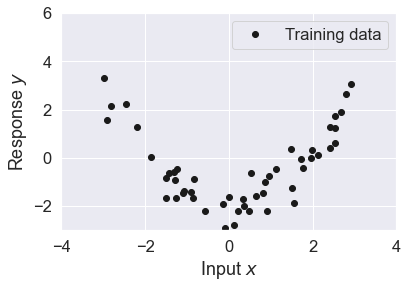

In [8]:
# load data
data = np.load('assignment2_data.npz')
N = data['N']
X = data['X']
y = data['y']

plt.plot(X, y, 'k.', markersize=12, label='Training data')
plt.grid(True)
plt.xlim((-4, 4))
plt.ylim((-3, 6))
plt.xlabel('Input $x$')
plt.ylabel('Response $y$')
plt.legend();


**Task 3a**: Complete the implementation of the function <tt>posterior</tt> that computes the posterior

\begin{align*}
p(f_* | X,y,X^p) = \mathcal{N} \left(f_* \big| K_{f_* f} K_{ff}^{-1} y, K_{f_* f_*} - K_{f_* f} K_{ff}^{-1} K_{f_* f}^T \right)
\end{align*}

### 3a (posterior implementation)

In [ ]:
def posterior(Xp, X, y, alpha, scale, sigma2):
    """ returns the posterior distribution of f evaluated at each of the points in Xp conditioned on (X, y)
        using the squared exponential kernel.
    
    Arguments:
    Xp    -- PxD prediction points
    X     -- NxD input points
    y     -- Nx1 observed values 
    alpha -- hyperparameter
    scale -- hyperparameter
    sigma2 -- noise variance
    
    returns Px1 mean vector and PxP covariance matrix
    """
    
    K_ff = create_se_kernel(X,X,alpha, scale)
    k_fxf = create_se_kernel(Xp,X,alpha, scale)
    K_fxfx = create_se_kernel(Xp,Xp,alpha,scale)
    
    L = np.linalg.cholesky(K_ff + sigma2*np.eye(K_ff.shape[0]))
    
    v = np.linalg.solve(L,k_fxf.T)
    w = np.linalg.solve(L,y)

    mu = v.T@w
    Sigma = K_fxfx - v.T@v
    return mu, Sigma



**Task 3b**: Compute the prior & posterior of $f(\mathbf{X}_p)$ with $\sigma^2 = \frac{1}{2}$, $\alpha=1$, and <tt>scale</tt>=2, where $\mathbf{X}_p$ is the vector from task 1.

### 3b (prior and posterior for $f(X_p)$ )

**NOTE: There is some inconsistancy with task description and code. Code has scale=1, task says 2. I am using scale 1, since I already made the comments/explanations with that value. I hope this is not a problem. For later incosistancies, I will go with the task description.**

In [10]:
sigma2 = 0.5
alpha = 1
scale = 1


# prior mean and covariance
mu_prior, Sigma_prior = np.zeros_like(Xp), create_se_kernel(Xp,Xp, alpha, scale)

# posterior mean and covariance
mu_post, Sigma_post = posterior(Xp,X,y,alpha, scale, sigma2)
    

**Task 3c**: If the functions above have been implemented correctly, then the following two plots below will show the training data superimposed with prior and posterior, respectively. First, explain what you see in the two figures. Second, what is the difference between the prior and the posterior in 1) regions close to the data points 2) in regions far from the data points?



### 3c (plots)

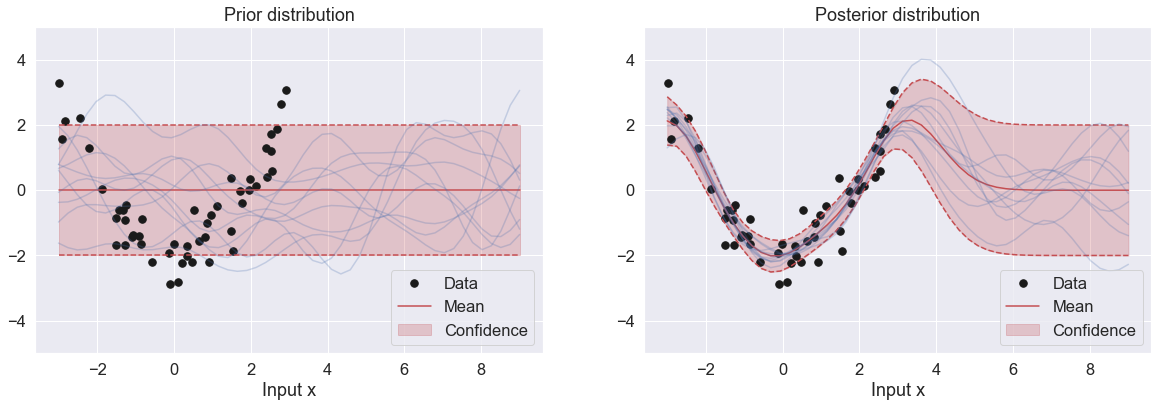

In [11]:
def plot_with_uncertainty(Xp, mu, Sigma, color='r', color_samples='b', title="", num_samples=0):
    
    mean, std = mu.ravel(), np.sqrt(np.diag(Sigma))

    
    # plot distribution
    plt.plot(Xp, mean, color=color, label='Mean')
    plt.plot(Xp, mean + 2*std, color=color, linestyle='--')
    plt.plot(Xp, mean - 2*std, color=color, linestyle='--')
    plt.fill_between(Xp.ravel(), mean - 2*std, mean + 2*std, color=color, alpha=0.25, label='Confidence')
    
    # generate samples
    if num_samples > 0:
        fs = generate_samples(mu, Sigma, 10)
        plt.plot(Xp, fs, color=color_samples, alpha=.25)
    
    plt.title(title)
    
def plot_data():
    plt.plot(X, y, 'k.', markersize=15, label='Data')
    plt.xlabel('Input x')
    plt.ylim((-5, 5))
    plt.grid(True)

    
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plot_data()
plot_with_uncertainty(Xp, mu_prior, Sigma_prior, title='Prior distribution', num_samples=10)
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plot_data()
plot_with_uncertainty(Xp, mu_post, Sigma_post, title='Posterior distribution', num_samples=10)
plt.legend(loc='lower right')




**Explanations:**

Figure on left shows samples from (GP) prior (light blue) with 2 sdv confidence. Prior is un-affected by the data (it reflects what we know/assume before seeing the data). Our confidence is constant everywhere.

Figure on the right shows samples from posterior (light blue) with 2 sdv confidence. Close to the data, the likelihood/data dominates and the function is fairly confident. As we move further from data (x\~3 onwards), the posterior reverts to(-wards) the prior. Roughly from x~6 onwards there is no difference between prior and posterior. Far from the data, posterior mean is the same as prior mean (zero).

**Task 3d**: Replicate the two figures above for the following three different values of the scale parameter: $\left\lbrace 0.25, 1, 5 \right\rbrace$ and for $\sigma^2 = \frac{1}{2}$ and $\alpha=1$. Explain the differences between the three sets of plots


### 3d (plots)
**NOTE: There were different default values in the notebook template, [0.1, 1, 5]. However, I'm using the above mentioned 0.25 as the first value (there's no qualitative difference - both demonstrate the short lengthscale well enough).**

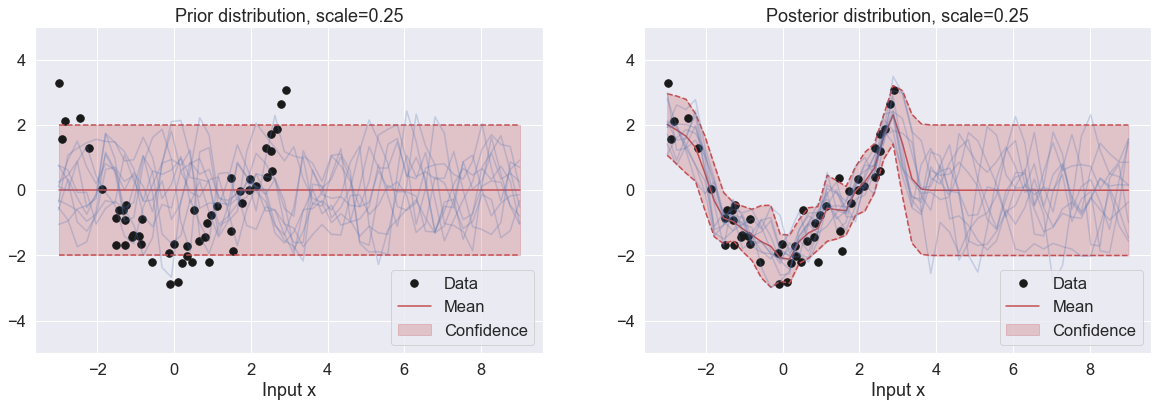

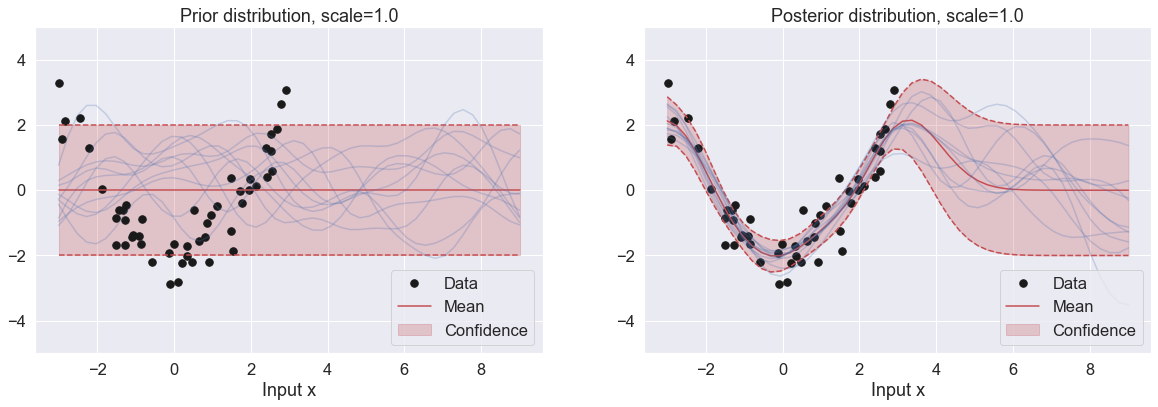

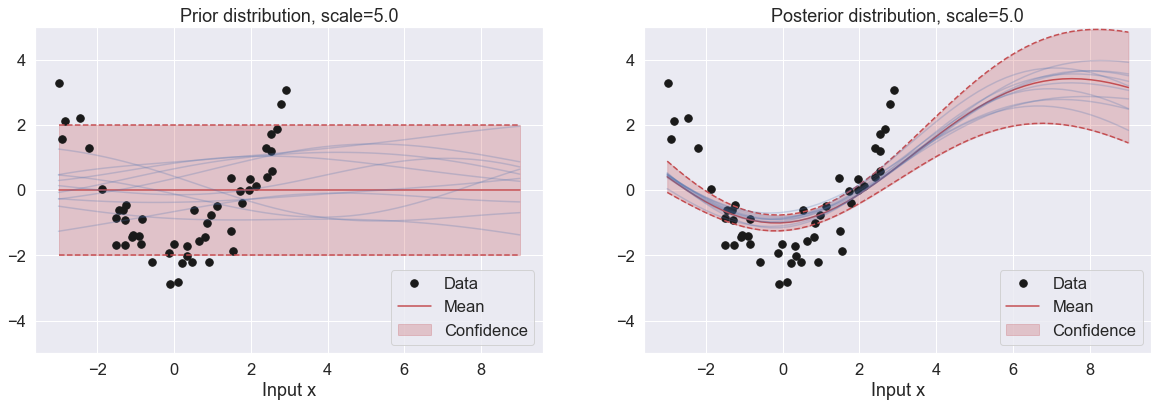

In [ ]:
sigma2=0.5
alpha=1
scales = [0.25, 1., 5.]

# posterior mean and covariance
for i in range(3):
    mu_prior, Sigma_prior = np.zeros_like(Xp), create_se_kernel(Xp,Xp, alpha, scales[i])
    mu_post, Sigma_post = posterior(Xp,X,y,alpha, scales[i], sigma2)

    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plot_data()
    plot_with_uncertainty(Xp, mu_prior, Sigma_prior, title='Prior distribution, scale={}'.format(scales[i]), num_samples=10)
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plot_data()
    plot_with_uncertainty(Xp, mu_post, Sigma_post, title='Posterior distribution, scale={}'.format(scales[i]), num_samples=10)
    plt.legend(loc='lower right')


**Explanations:**

**Top row (overfitting)**: with short lengthscale, our priors are very non-smooth and able to fit to noise. Therefore the posterior is clearly overfitting. The confidence interval is also relatively wide, since we are not able to increase our certainty by accounting the effects of furtherout data (this is the negative contribution in the posterior covariance formula). Posterior reverts to mean very fast when there are no nearby datapoints.

**middle row**. Now the priors are relatively smooth, but still expressive enough to account the variability in the data. The posterior fits the data well, and with reasonable certainty (more datapoints are contributing to each value). Now it takes longer for the posterior mean to revert to prior mean, when there are no nearby datapoints.

**bottom row (underfitting)**. Now the priors are very stiff, and constrain the posterior too much. The posterior has become more certain since it's averaging over a longer distance/window. The model is clearly too "simple", and the posterior is unable to fit the data. Even far from the data, the posterior mean is clearly different from the prior mean. 

**Task 3e**: Replicate the two figures above for the following three different values of the alpa parameter: $\left\lbrace 0.25, 1, 5 \right\rbrace$ and for $\sigma^2 = \frac{1}{2}$ and $\text{scale}=1$. Explain the differences between the three sets of plots


### 3e (plots)

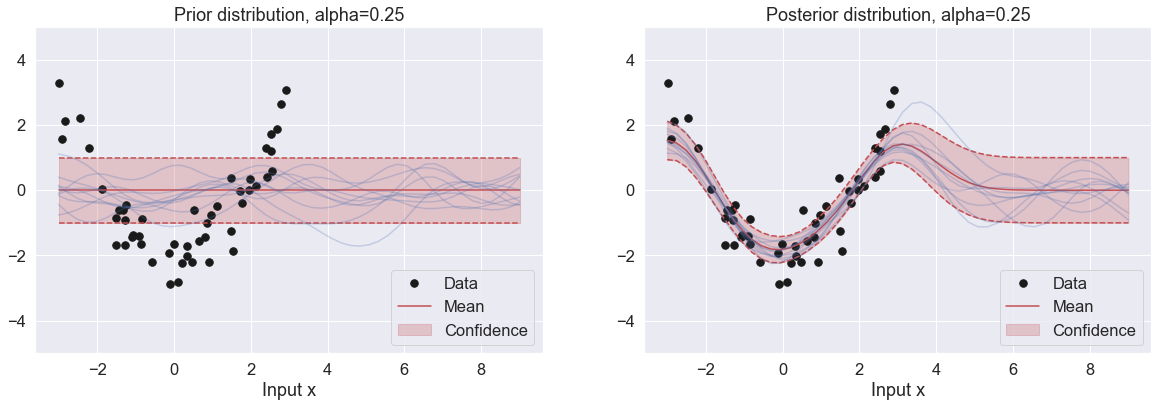

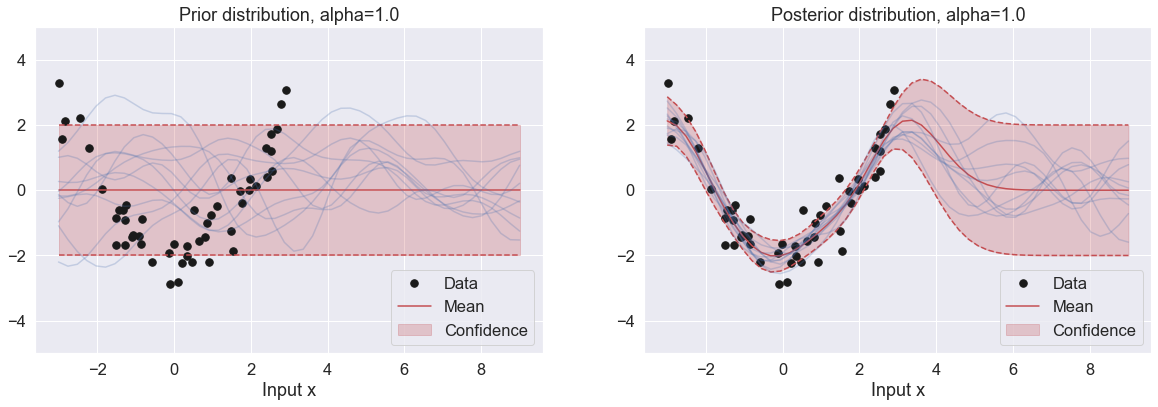

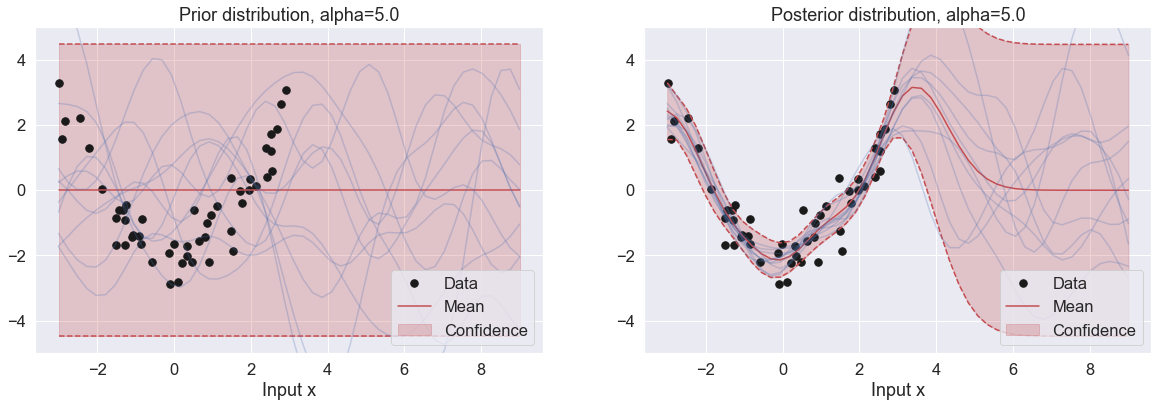

In [ ]:
sigma2=0.5
scale=1
alphas = [0.25, 1., 5.]

for i in range(3):
    mu_prior, Sigma_prior = np.zeros_like(Xp), create_se_kernel(Xp,Xp, alphas[i], scale)
    mu_post, Sigma_post = posterior(Xp,X,y,alphas[i], scale, sigma2)

    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plot_data()
    plot_with_uncertainty(Xp, mu_prior, Sigma_prior, title='Prior distribution, alpha={}'.format(alphas[i]), num_samples=10)
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plot_data()
    plot_with_uncertainty(Xp, mu_post, Sigma_post, title='Posterior distribution, alpha={}'.format(alphas[i]), num_samples=10)
    plt.legend(loc='lower right')


**Explanations**

**top row:** Prior has small signal amplitude/variance (the 2 sdv constant confidence is proportional to it). The amplitude determines how large variations these processes can describe (in non-local sense), and so, conditioning on the data can not make the posterior fit properly: eventhough the lengthscale is relatively short, the magnitude also contributes to the expressiveness of the model. With too small signal magnitude/variance, the posterior can't model large enough variations in the data (non-local sense). In some sense, zero mean GP prior with 0.25 variance can not explain/model data which varies (at least) between ~[-3,3]. Far from the data, the posterior reverts to the prior with relatively high confidence.

**middle row:** Now the prior variance/magnitude is large enough that we could expect such processes to explain the data. Far from data, the posterior is naturally less confident.

**Bottom row:** With high variance, the posterior can easily represent the global variability in the data, and since the lengthscale is reasonable, it also fits the data well. The large variance makes the model very uncertain when there is no nearby data.

As long as the prior has enough variability/magnitude to represent the global variability in the data, and the lengthscale is small enough for the prior to respond to the local variability in the data, the posterior will fit the data equally well (middle, bottom). However, when extrapolating far from data, high variability leads to more uncertainty (from generative modelling perspective: there are far more processes that "could have" produced the data). Regardless of magnitude, all of the above models (posterior means) revert to the prior mean at similar rate - this is modulated by the lengthscale.

### Task 4: The marginal likelihood

The purpose of this task is to study the marginal likelihood $p(\mathbf{y})$ and see how it can be useful for model selection. 

The marginal likelihood is covered in lecture #3.

The marginal likelihood for a zero-mean Gaussian process model with Gaussian likelihood is given by

\begin{align}
p(\mathbf{y} \big| \theta) = \mathcal{N}\left(\bf{y} \big| \bf{0}, \bf{K} + \sigma^2 \bf{I}\right)
\end{align}

where $\theta$ are the set of hyperparameters, e.g. the alpha and scale parameters.

First, we will load some validation data that will be useful for evaluating the model.


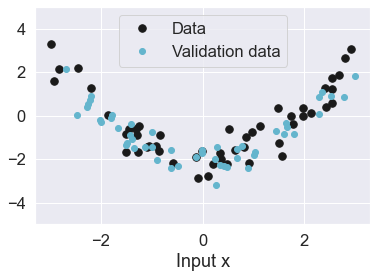

In [14]:
Nval, Xval, yval = data['Nval'], data['Xval'], data['yval']

plot_data()
plt.plot(Xval, yval, 'c.', label='Validation data', markersize=12)
plt.legend(loc='upper center');


**Task 4a**: Complete the implementation of the function <tt>predictive</tt> below. The predictive distribution of 'yp' combines prediction function posterior (<tt>posterior</tt>) and the noise variance.


### 4a (predictive implementation)

In [ ]:
def predictive(Xp, X, y, alpha, scale, sigma2):
    """ returns the predictive distribution of yp 
    evaluated at each of the points in Xp conditioned on (X, y)
    
    Arguments:
    Xp    -- PxD prediction points
    X     -- NxD input points
    y     -- Nx1 observed values 
    alpha -- hyperparameter
    scale -- hyperparameter
    sigma2 -- noise variance
    
    returns Px1 mean vector and PxP covariance matrix
    """
    m, S = posterior(Xp, X, y, alpha, scale, sigma2)
    return m, S + sigma2*np.eye(S.shape[0])


**Task 4b**: Complete the implementation of the function <tt>MLPPD</tt> for computing the mean log posterior predictive density given below.


### 4b (mlppd implementation)

In [ ]:
log_npdf = lambda x, m, v: -0.5*(x-m)**2/v -0.5* np.log(2*np.pi*v)

def MLPPD(Xval, yval, mu, Sigma):
    """ returns the mean log posterior predictive density 
    for the data points (Xval, yval) wrt. predictive density N(mu, Sigma)
    
    Arguments:
    Xval      -- PxD input points
    yval      -- px1 observed values 
    mu        -- Dx1 mean of predictive distribution
    Sigma     -- DxD covariance of predictive distribution

    Returns
    mlppd     -- (scalar) mean log posterior predictive density
    
    """
    S = np.diag(Sigma)
    mlppd = np.mean([log_npdf(yval[i],mu[i],S[i]) for i in range(len(yval))])
    
    return mlppd




**Task 4c**: Complete the implementation of the function <tt>log_marginal_likelihood</tt>  given below.


### 4c (log_marginal_likelihood implementation)

In [ ]:
def log_marginal_likelihood(X, y, alpha, scale, sigma2):
    """ returns the log marginal likelihood for the data set (X, y) for the hyperparameters alpha, scale, sigma2
        The function also returns the components of the log marginal likelihood:
        
        log_ml = const_term + det_term + quad_term
    
    Arguments:
    X        -- NxD input points
    y        -- Nx1 observed values 
    alpha    -- alpha parameter
    scale    -- scale parameter
    sigma2   -- noise variance

    Returns:
    log_ml   -- (scalar) log marginal likelihood ( = const + det + quad)
    const    -- constant part of the log marginal lihood
    det      -- determinant part of the log marginal lihood
    quad     -- quadratic part of the log marginal lihood
    
    """
    K = create_se_kernel(X,X,alpha, scale)
    L = np.linalg.cholesky(K + sigma2*np.eye(K.shape[0]))
    v = np.linalg.solve(L,y).flatten()
    quad_term = - .5 * v.T@v
    const_term = -.5 * len(y) * np.log(2*np.pi)
    det_term = - np.sum(np.log(np.diag(L)))
    log_ml = const_term + det_term + quad_term
    return log_ml, const_term, det_term, quad_term





**Task 4d**: Compute and plot the marginal likelihood as a function of the scale parameter in the interval $\left[0.01, 100\right]$ using the scales vector (<tt>scales</tt>) given below. In the same figure, you should also plot the determinant and the quadractic part of the marginal likelihood. Note, that the scale values are distributed equally in log-space. Use $\sigma^2 = 0.5$ and $\alpha=1$. The scale axis should be logaritmic in the plot. Furthermore, locate the optimal value of the scale and plot the posterior distribution of $f(\bf{X}_p)$ for the that specific value.

**Task 4e**: Compute and plot the MLPPD of the validation set $\left( \bf{X}_{\text{val}}, \bf{y}_{\text{val}}\right)$ as a function of the scale parameter in the interval $\left[0.01, 100\right]$ using the scales vector (<tt>scales</tt>) given below. Note, the scale values are distributed equally in log-space. Use $\sigma^2 = 0.5$ and $\alpha=1$. The scale axis should be logaritmic in the plot.


**Task 4f**: Compare the two plots above and explain what you see. 


### 4d (calculate marginal likelihood, det, quad  and determine the optimum)

In [ ]:
scales = np.logspace(-2, 2, 100)
sigma2=0.5
alpha=1

# 4d - marginal likelihood (of X) as a function of scale
marg_X = np.zeros((100,3))
for i in range(100):
    marg_X[i,:]=np.array(log_marginal_likelihood(X,y,alpha, scales[i], sigma2))[[0,2,3]]
ind_max = np.where(marg_X[:,0]==np.amax(marg_X[:,0]))

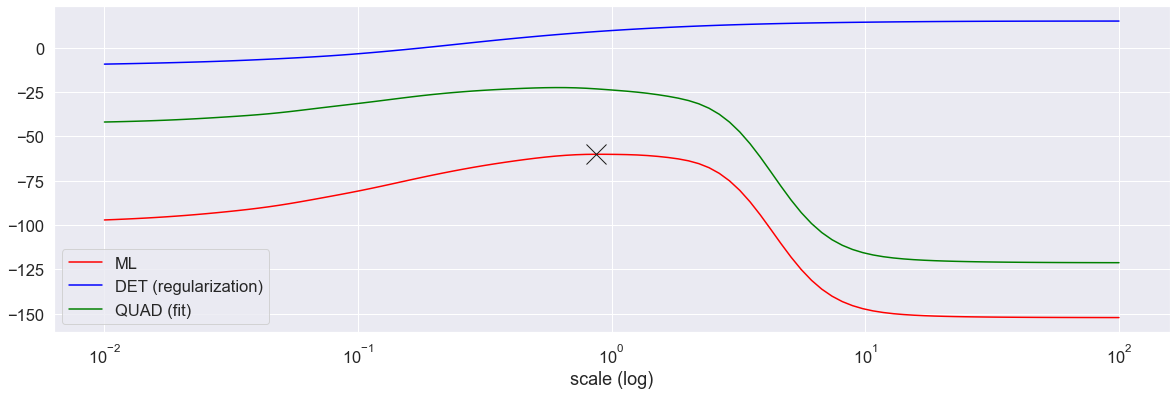

In [19]:
colors = ['red','blue','green']
plt.figure(figsize=(20, 6))
for i in range(3):
    plt.plot(scales, marg_X[:,i],colors[i])
plt.plot(scales[ind_max],marg_X[ind_max,0],'kx', markersize=20)
plt.xscale('log')
plt.xlabel('scale (log)')
plt.legend(['ML','DET (regularization)','QUAD (fit)'])
plt.show()

**NOTE**: I am picking the optimum with numpy amax. However, there is almost constant ML value for scale in [0.87,1.0]. I keep the numpy amax one (0.87), but by Occams razor one could just as well favour the smoother/simpler model (scale=1).

### 4d (plot the posterior with optimal scale)

**NOTE:** I am also plotting the validation data (in blue dots) - just out of interest. TA can also remove them (check comment below).

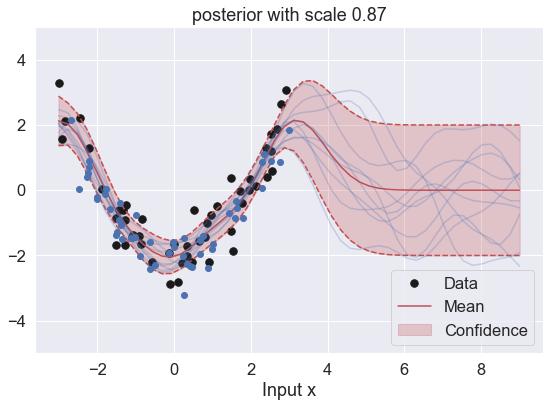

In [20]:
scale_max = scales[ind_max].item()
mu_post, Sigma_post = posterior(Xp,X,y,alpha, scale_max, sigma2)
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plot_data()
plot_with_uncertainty(Xp, mu_post, Sigma_post, title='posterior with scale {}'.format(np.round(scale_max,2)), num_samples=10)
#THIS IS NOT NECESSARY, I WAS JUST CURIOUS...
plt.plot(Xval,yval,'bo')
plt.legend(loc='lower right')
plt.show()

### 4e (compute and plot MLPPD for Xval, yval)

**NOTE:** Out of interest, I also pinpoint the value which would give maximum based on validation set mlppd).

In [21]:
def mlppd_foo(s):
    mu_pred, Sigma_pred = predictive(Xval,X,y,alpha,s,sigma2)
    return MLPPD(None, yval,mu_pred ,Sigma_pred)

In [22]:
mlppd = np.vectorize(mlppd_foo)(scales)
ind_max_val = np.where(mlppd==np.amax(mlppd))

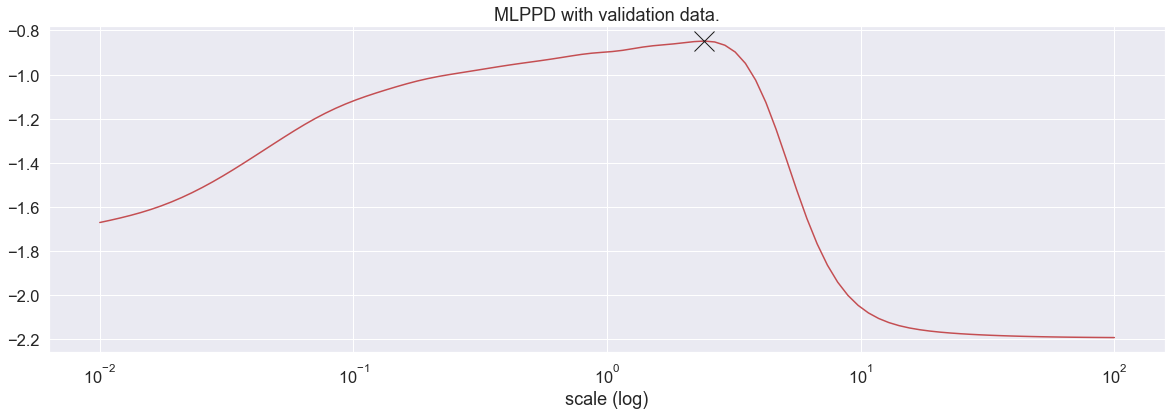

In [23]:
plt.figure(figsize=(20, 6))
plt.plot(scales,mlppd,'r')
plt.plot(scales[ind_max_val],mlppd[ind_max_val],'kx', markersize=20)
plt.xscale('log')
plt.xlabel('scale (log)')
plt.title('MLPPD with validation data.')
plt.show()

### 4f (Explanations)

I repeat the plot here for clarity:

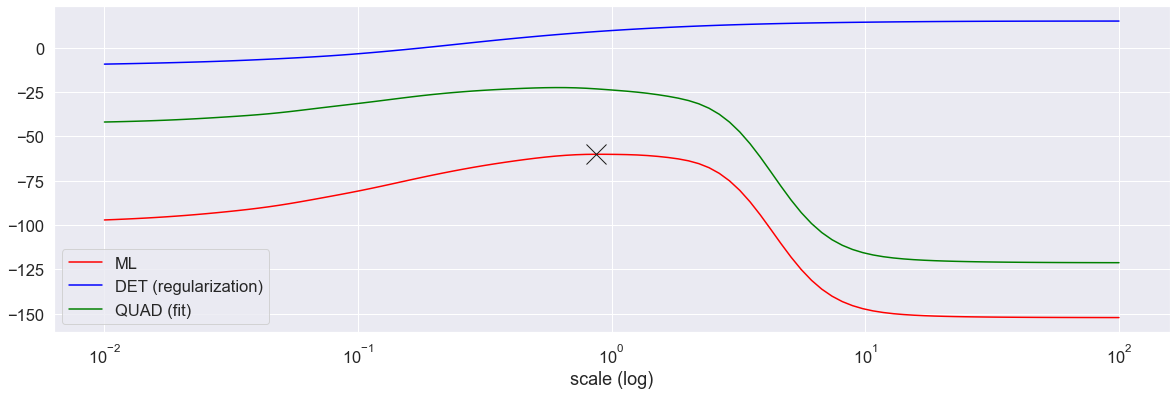

In [24]:
colors = ['red','blue','green']
plt.figure(figsize=(20, 6))
for i in range(3):
    plt.plot(scales, marg_X[:,i],colors[i])
plt.plot(scales[ind_max],marg_X[ind_max,0],'kx', markersize=20)
plt.xscale('log')
plt.xlabel('scale (log)')
plt.legend(['ML','DET (regularization)','QUAD (fit)'])
plt.show()

The blue line corresponds to the *negative of the log determinant*, i.e., it gets higher values the simpler the covariance is. From traditional learning theory perspective, it can be viewed as a regularization curve: the more regularization, the simpler the model - this corresponds to large lengthscale and smooth function. Smoother function gives-up fit for (typically) better generalization.

The green line corresponds to the fit, i.e., how accurately we can fit the data with the model. More complicated model (short lengthscale, wiggly GPs), the less averaging, less smoothness, higher risk to fit to noise - but pointwise error (on mean, on training data) is also smaller. However, with too small lengthscale, uncertainty can not be reduced by integrating information from proximity (confidence is reduced also for very small lengthscales). The same term that reduces confidence for very small lengthscales, is exactly the quad term (this results in a approx~convex quad term).

The red line takes into account the both effects (plus constant). Compared to non-Bayesian counterpart, the typical training/validation error curves and the problem of regularization, the Bayesian approach also considers model uncertainty (in addition to balancing between over-/underfitting). The maximum is attained at a point where the model can not just explain the data well, it also does it with reasonable certainty.

**Comparing to the validation data and MLPPD**:

On validation data, it is not surprising that smoother model (compared to the marginal log likelihood/evidence) would perform better. It is typical, that more regularized/constrained models generalize to unseen data better. 

However, using the validation data to pick the hyperparameter value does not seem like a ideal approach (data snooping?); one should rather just include the validation data into the training set, and optimize the marginal likelihood on the whole set. 

For validation, the mlppd curve still shows the chosen lengthscale (0.87) performs relatively well, and the posterior seems to fit the validation points well (some extra plots below). Overall, the behaviour of the MLPPD curve is similar to the ML curve (both reflect the bias-variance trade-off, when plotted over the scale hyperparameter). Too flexible model can fit noise, and cannot reduce uncertainty by integrating information over a window (proportional to lengthscale) - too smooth function cannot represent the variability in the data.

**(EXTRA FROM HERE ON) Some posterior plots for the validation data (blue dots)**

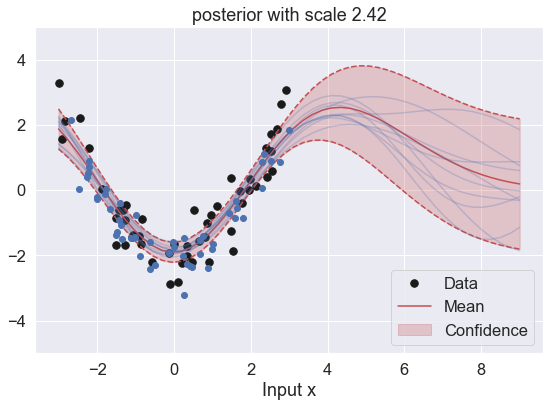

In [25]:
scale_max_val = scales[ind_max_val].item()
mu_post, Sigma_post = posterior(Xp,X,y,alpha, scale_max_val, sigma2)
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plot_data()
plot_with_uncertainty(Xp, mu_post, Sigma_post, title='posterior with scale {}'.format(np.round(scale_max_val,2)), num_samples=10)
plt.legend(loc='lower right')
plt.plot(Xval,yval,'bo')
plt.show()


Underneath, there is a demonstration how the smoother model (longer lengthscales) produces also more certain/confident prediction in the proximity of the data. Below are the training data, and the validation data with both lengthscales (posterior).

In [26]:
tt = np.sort(Xval,0)

Text(0.5, 1.0, 'scale is 0.87, from ML.')

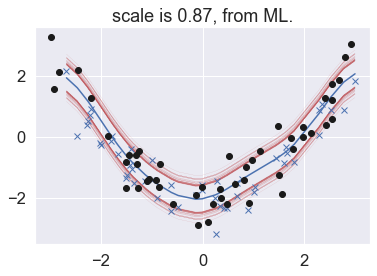

In [27]:
poster = posterior(tt,X,y,alpha,scale_max,sigma2)
plt.plot(tt,poster[0])
plt.plot(tt,poster[0]+2*np.sqrt(np.diag(poster[1])),'r--',linewidth=.1)
plt.plot(tt,poster[0]-2*np.sqrt(np.diag(poster[1])),'r--',linewidth=.1)
plt.plot(Xval,yval,'bx')
plt.plot(X,y,'ko')
plt.title("scale is {}, from ML.".format(np.round(scale_max,2)))

Text(0.5, 1.0, 'scale is 2.42, from mlppd.')

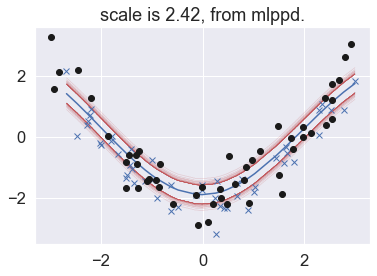

In [28]:
poster = posterior(tt,X,y,alpha,scale_max_val,sigma2)
plt.plot(tt,poster[0])
plt.plot(tt,poster[0]+2*np.sqrt(np.diag(poster[1])),'r--',linewidth=.1)
plt.plot(tt,poster[0]-2*np.sqrt(np.diag(poster[1])),'r--',linewidth=.1)
plt.plot(Xval,yval,'bx')
plt.plot(X,y,'ko')
plt.title("scale is {}, from mlppd.".format(np.round(scale_max_val,2)))